<a href="https://colab.research.google.com/github/laurence-lin/Working-files/blob/main/train_txt_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np

import os

from tensorflow.keras.applications import ResNet50
import cv2

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
import tensorflow as tf
import matplotlib.pyplot as plt

import time
import gc


In [2]:
!nvidia-smi

Wed Feb  3 01:21:02 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.39       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
image_path = '/content/drive/MyDrive/binary'

In [6]:
# HYPER PARAMETERS SETTING

IMAGE_WIDTH = 500
IMAGE_HEIGHT = 600
BATCH_SIZE = 16


In [7]:

train_loader = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode = 'categorical',
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'training',
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    seed = 123
    )

valid_loader = keras.preprocessing.image_dataset_from_directory(
    image_path,
    label_mode = 'categorical',
    validation_split = 0.2,
    color_mode = 'rgb',
    subset = 'validation',
    image_size = (IMAGE_WIDTH, IMAGE_HEIGHT),
    batch_size = BATCH_SIZE,
    seed = 123
    )


Found 400 files belonging to 3 classes.
Using 320 files for training.
Found 400 files belonging to 3 classes.
Using 80 files for validation.


In [8]:
# Define model

FREEZE_LAYER = 2
classes = 2

# Define model
base_model = ResNet50(
    include_top = False,
    input_shape = (IMAGE_WIDTH, IMAGE_HEIGHT, 3),
    weights = 'imagenet'
    #classes = 2
    )

def build_model(base_model):
    # Build custom model for the pre-trained resnet50
    
    x = base_model.output
    x = keras.layers.Flatten()(x)
    x = keras.layers.Dropout(0.5)(x)
    
    output = keras.layers.Dense(classes, activation = 'softmax', name='softmax')(x)
    
    final_model = keras.Model(inputs = base_model.input, 
                        outputs = output)
    
    for layer in final_model.layers[:FREEZE_LAYER]:
        layer.trainable = False
        
    for layer in final_model.layers[FREEZE_LAYER:]:
        layer.trainable = True
    
    return final_model
    
model = build_model(base_model)


94773248/94765736 [==============================] - 1s 0us/step


In [9]:
model.compile(
    optimizer = keras.optimizers.Adam(1e-5),
    loss = tf.losses.BinaryCrossentropy(from_logits = True),
    metrics=['accuracy']
    )

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 500, 600, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 506, 606, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 250, 300, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 250, 300, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [10]:
model.fit(
    train_loader,
    validation_data = valid_loader,
    epochs = 10
    )

Epoch 1/10


ValueError: ignored

In [ ]:
# Save model on drive 
model.save('txt_overlap_model1')
!cp -r txt_overlap_model1 '/content/drive/MyDrive/binary/txt_overlap_model1'

In [14]:


def preprocess_img(img):
  '''
  img: input image directory
  output: processed image array could feed to predictive model

  '''

  img1 = plt.imread(img)
  img1 = cv2.resize(img1, (IMAGE_HEIGHT, IMAGE_WIDTH))
  img1 = cv2.cvtColor(img1, cv2.COLOR_RGBA2RGB)
  img1 = np.expand_dims(img1, axis = 0)

  return img1

class_labels = {'0':'normal', '1':'overlap'}

def decode_prediction(pred):

  predict = np.argmax(pred[0])
  predict_label = class_labels[str(predict)]

  return predict_label


In [22]:
import glob

model = keras.models.load_model('/content/drive/MyDrive/binary/txt_overlap_model1')

images = glob.glob('/content/drive/MyDrive/binary/normal/*.png')
images = images + glob.glob('/content/drive/MyDrive/binary/overlap/*.png')

predictions = []

for img in images:

  image = preprocess_img(img)

  predict = model.predict(image)

  predict_label = decode_prediction(predict)

  predictions.append(predict_label)

print('Predicted {} samples.'.format(len(predictions)))


Predicted 400 samples.


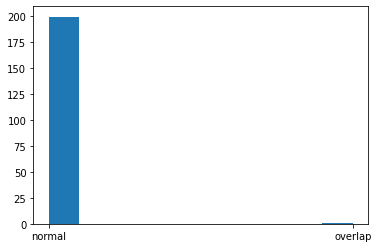

In [20]:
plt.hist(predictions[:])

plt.show()

In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Tue Feb  2 17:17:12 2021

@author: lawrence123
"""

# Visualize object in image: Grad CAM
import tensorflow as tf
import tensorflow.keras as keras
import cv2
import imutils

from keras import Model as Model

# import the necessary packages

class GradCAM():
  def __init__(self, model, classIdx, layerName=None):
    # store the model, the class index used to measure the class
    # activation map, and the layer to be used when visualizing
    # the class activation map
    self.model = model
    self.classIdx = classIdx
    self.layerName = layerName
    # if the layer name is None, attempt to automatically find
    # the target output layer
    if self.layerName == None:
    	self.layerName = self.find_target_layer()
   
  def find_target_layer(self):
    # attempt to find the final convolutional layer in the network
    # by looping over the layers of the network in reverse order
    for layer in reversed(self.model.layers):
    	# check to see if the layer has a 4D output
    	if len(layer.output_shape) == 4:
	    		return layer.name
		# otherwise, we could not find a 4D layer so the GradCAM
    # algorithm cannot be applied
    raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")
  
  def compute_heatmap(self, image, eps=1e-8):
    # construct our gradient model by supplying (1) the inputs
    # to our pre-trained model, (2) the output of the (presumably)
    # final 4D layer in the network, and (3) the output of the
    # softmax activations from the model
    gradModel = Model(
      inputs=[self.model.inputs],
      outputs=[self.model.get_layer(self.layerName).output, self.model.output])

    # record operations for automatic differentiation
    with tf.GradientTape() as tape:
    # cast the image tensor to a float-32 data type, pass the
    # image through the gradient model, and grab the loss
    # associated with the specific class index
      inputs = tf.cast(image, tf.float32)
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, self.classIdx]
    # use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
    # the convolution and guided gradients have a batch dimension
    # (which we don't need) so let's grab the volume itself and
    # discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]

    # compute the average of the gradient values, and using them
    # as weights, compute the ponderation of the filters with
    # respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
 
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    (w, h) = (image.shape[2], image.shape[1])
    heatmap = cv2.resize(cam.numpy(), (w, h))
		# normalize the heatmap such that all values lie in the range
		# [0, 1], scale the resulting values to the range [0, 255],
		# and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    heatmap = (heatmap * 255).astype("uint8")
		# return the resulting heatmap to the calling function
    return heatmap

  def overlay_heatmap(self, heatmap, image, alpha=0.5, colormap=cv2.COLORMAP_VIRIDIS):
		# apply the supplied color map to the heatmap and then
		# overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
		# return a 2-tuple of the color mapped heatmap and the output,
		# overlaid image
        return (heatmap, output)


In [ ]:
from keras.applications.resnet50 import decode_predictions

preds = model.predict(img1)

class_labels = {'0':'normal', '1':'overlap'}

def decode_prediction(pred):

  predict = np.argmax(pred[0])
  predict_label = class_labels[str(predict)]

  return predict_label

i = np.argmax(preds[0])
# decode the ImageNet predictions to obtain the human-readable label
decoded = decode_prediction(preds)



(imagenetID, label, prob) = decoded[0][0]
label = "{}: {:.2f}%".format(label, prob * 100)
print("[INFO] {}".format(label))


In [ ]:
i